# Crowded field photometry --- 1b. NIRCam parallel imaging

This notebook demonstrates how to create JWST data by using [MIRAGE](https://mirage-data-simulator.readthedocs.io/en/latest/).
This is one of series of notebooks that focus on crwoded field photometry (see other notebooks in the directory).


This notebook will demonstrate how to create NIRISS WFSS and direct image simulation. It will require the following input files;
1. APT output files (.xml and .pointing) that specify the observation
2. A source catalog that lists source properties (magnitude/morphology...), taken from HST.

Users may also provide their catalog/apt files, to create own scenes, but may need to allocate columns for physical parameters.


## To Do:
- 1.Read input catalogs
- 2.Generate two Mirage friendly source catalogs (one for point source, and the other for extended).
- 3.Generate a set of yaml files, setup files for Mirage.
- 4.Run simulation for NIRCAM parallel images.

*Reduction of these generated raw data will be demonstrated in another notebook.

### Requirement:
- Mirage environment. [see here](https://mirage-data-simulator.readthedocs.io/en/latest/install.html)


### It is recommended to run this notebook after 1a, as detailed explanations can be found there.

In [1]:
%matplotlib inline

In [2]:
# Set environment variables
# It may be helpful to set these within your .bashrc or .cshrc file, so that CRDS will
# know where to look for reference files during future runs of the JWST calibration
# pipeline.
import os
os.environ["MIRAGE_DATA"] = "/ifs/jwst/wit/mirage_data/"
os.environ["CRDS_PATH"] = os.path.join(os.path.expandvars('$HOME'), "crds_cache")
os.environ["CDRS_SERVER_URL"]="https://jwst-cdrs.stsci.edu"

In [3]:
from glob import glob
import pkg_resources
import yaml

from astropy.io import fits
import astropy.units as u
from astropy.visualization import simple_norm, imshow_norm
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mirage import imaging_simulator
from mirage import wfss_simulator
from mirage.utils.constants import FLAMBDA_CGS_UNITS, FLAMBDA_MKS_UNITS, FNU_CGS_UNITS 
from mirage.yaml import yaml_generator

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/pysynphot/locations.py:47: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [4]:
import mirage
import astropy

print(mirage.__version__)
print(astropy.__version__)

1.2.3.dev10+geb23408
4.0


### The flow should be similar to example 1a.

---
<a id='yaml_from_apt'></a>
## Create a series of yaml files from [APT](https://jwst-docs.stsci.edu/display/JPP/JWST+Astronomers+Proposal+Tool+Overview)

To set Mirage up for your observation designed in APT, you need to get .xml and .pointing files out of your APT file and provide them to Mirage.
You can get these files from APT's tool bar ([File]->[Export]).

As an example, observation here is taken from [GLASS-ERS](http://www.stsci.edu/jwst/observing-programs/approved-ers-programs/program-1324). Some modifications were added.

In [5]:
# Input files from APT
# These can be obtained from a tab, [File]->[Export], in APT.
# There is some modification:
# 1.Deep direct imaging (3600s per exposure)
# 2. Cut out NIRCam parallel imaging, and NIRSPEC observations, to run through the notebook here.

xml_file = './A2744_example_nrcb_par.xml' 
pointing_file = './A2744_example_nrcb_par.pointing'

In [7]:
# Set reference file values. 
# Setting to 'crds_full_name' will search for and download needed
# calibration reference files (commonly referred to as CRDS reference files) when
# the yaml_generator is run. 
# 
# Setting to 'crds' will put placeholders in the yaml files and save the downloading
# for when the simulated images are created.
reffile_defaults = 'crds'

# Optionally set the cosmic ray library and rate
cosmic_rays = {'library': 'SUNMAX', 'scale': 1.0}

# Optionally set the observation date to use for the data. Note that this information
# is placed in the headers of the output files, but not used by Mirage in any way.
dates = '2022-07-01'

In [8]:
# Optionally set the background signal rates to be used
# As in Cami's note, this may not work.
background = 'low' #'medium'

In [9]:
# Optionally set the telescope roll angle (PAV3) for the observations
pav3 = 0 #12.5 + 45.

In [10]:
datatype = 'raw'

### NIRCam parallel imaging;

### Create catalog for parallel field;

In [11]:
# Read the original catalog;
PARFLD    = 'abell2744par'
PARFLDID  = '11'
mag0   = 25.0

from astropy.io import ascii

# This is for flux, where the magnitude zeropoint is mag0.
t = ascii.read('./input_%s.cat'%(PARFLDID))
t

id,F202,E202,F203,E203,F204,E204,F205,E205,F1,E1,F4,E4,F6,E6,z_spec
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1.23619,0.0230367,1.56875,0.0356166,1.61386,0.0322021,1.59824,0.0282356,0.258878,0.0195364,0.350712,0.0185751,0.812315,0.0172994,-1.0
2,0.499945,0.0354705,0.509776,0.0484362,0.613706,0.0483386,0.645023,0.0425953,0.113634,0.026694,0.228174,0.024556,0.310336,0.0221176,-1.0
3,0.323907,0.0251387,0.399303,0.0361345,0.571337,0.0364724,0.701521,0.0302404,0.123508,0.0244825,0.154056,0.0223956,0.176447,0.0202482,-1.0
4,0.564852,0.0193321,0.675938,0.0279611,0.698947,0.0265529,0.715385,0.0232173,0.0944267,0.0226776,0.156319,0.0207415,0.407468,0.018717,-1.0
5,0.254462,0.0195938,0.400539,0.028633,0.443515,0.0268981,0.498619,0.023215,0.101303,0.0217205,0.126901,0.019838,0.183315,0.0178325,-1.0
6,0.739342,0.0356403,0.857438,0.0517026,0.886857,0.0491663,0.966068,0.0423337,0.215875,0.0404854,0.306219,0.0373658,0.557436,0.0338224,-1.0
7,2.67131,0.103948,3.75247,0.152872,4.43661,0.14589,5.04481,0.126589,1.12372,0.0908409,1.65981,0.0832307,2.11532,0.0748679,-1.0
8,18.8813,0.524858,23.3892,0.771158,25.7356,0.736091,27.4594,0.640142,1.64962,0.45264,4.20294,0.417389,10.6764,0.378896,-1.0
9,46.4289,0.023815,66.4719,0.0347721,80.7565,0.0326766,97.5238,0.0285702,1.01493,0.0280298,7.74424,0.02584,24.6394,0.0231751,-1.0


In [12]:
# Sectractor;
pixscale = 0.06
ts = ascii.read('./f160w_%s.cat'%(PARFLDID))

idsext = ts['NUMBER']
radius = ts['FLUX_RADIUS']*pixscale # in arcsec
elong  = ts['ELONGATION'] # = a/b
pa     = 90. - ts['THETA_IMAGE'] # Theta_mirage = 90 - Theta_Sext
magauto= ts['MAG_AUTO']
class_star = ts['CLASS_STAR']
ellip  = 1. - 1/elong

ts

NUMBER,MAG_AUTO,MAGERR_AUTO,KRON_RADIUS,BACKGROUND,X_WORLD,Y_WORLD,X_IMAGE,Y_IMAGE,THETA_IMAGE,ELONGATION,A_IMAGE,CLASS_STAR,FLUX_RADIUS,FLUX_RADIUS_1,FLAGS,ISOAREA_IMAGE,FLUX_AUTO,FLUXERR_AUTO,FLUX_APER,FLUX_APER_1,FLUX_APER_2,FLUXERR_APER,FLUXERR_APER_1,FLUXERR_APER_2,FLUX_ISO,FLUXERR_ISO
,mag,mag,,ct,deg,deg,pix,pix,deg,,pix,,pix,pix,,pix2,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,24.4979,23415631872.0,5.22,-8.353563e-05,3.4870597259,-30.403137239,1989.662,1416.722,-23.8,2.251,5.625,0.03,6.955,17.785,0,259,1.587967,34238710000.0,0.3333078,0.4589274,0.7007568,0.006810983,0.008524171,0.01246012,1.104851,0.01970381
2,25.4831,55360409600.0,7.56,0.0005023077,3.4601921285,-30.360832276,3380.346,3955.025,-53.9,1.47,2.67,0.02,10.597,15.099,0,70,0.6408781,32669680000.0,0.1107923,0.1529763,0.218499,0.007848716,0.00985288,0.01452227,0.1836552,0.01119502
3,25.3919,0.1039,7.18,0.001950061,3.4614628671,-30.363690716,3314.539,3783.526,86.1,1.627,7.332,0.03,7.211,12.375,3,316,0.697013,0.0666944,0.1508433,0.1925299,0.2617384,0.006310913,0.007914759,0.01135565,0.4658311,0.01905212
4,25.3706,0.0761,6.21,0.001525017,3.462633616,-30.363834243,3253.928,3774.92,56.3,2.112,7.418,0.01,6.837,12.752,3,339,0.710788,0.04983156,0.1196595,0.1706469,0.2862035,0.005216558,0.006515348,0.009348596,0.5294536,0.0163551
5,25.7626,0.0756,7.05,0.001411345,3.4625917509,-30.364088184,3256.094,3759.683,61.5,1.225,3.429,0.03,6.618,13.51,3,140,0.4954151,0.03447864,0.110698,0.146287,0.2098828,0.005493044,0.006862141,0.009835056,0.2427531,0.01101711
6,25.0445,0.0539,6.28,0.001705499,3.4627920124,-30.363068526,3245.732,3820.864,59.8,1.209,5.327,0.01,10.38,17.263,3,306,0.95986,0.04764317,0.09899884,0.1368591,0.2160578,0.005263997,0.006601038,0.009529023,0.4477313,0.01588479
7,23.2499,31977869312.0,6.08,0.0006339261,3.4609656911,-30.36106258,3340.295,3941.211,-30.4,4.462,14.206,0.03,53.277,70.831,3,415,5.012391,147592600000.0,0.24523,0.3263842,0.5060312,0.007119969,0.00887084,0.01277985,1.34889,0.02729353
8,21.4103,17927409664.0,5.55,0.0009540588,3.4609999916,-30.361236486,3338.519,3930.777,2.9,1.717,23.836,0.03,65.54,164.717,3,1832,27.28288,450378800000.0,0.2565572,0.3464023,0.5478848,0.007141311,0.008915041,0.01285513,11.04435,0.05232429


In [13]:
# Since SExtractor does not provide Sersic index;
# Set those bright, but extended object to n=4.
ser = radius * 0 + 1.0
con_ser = (magauto<20) & (class_star<0.9)
ser[con_ser] = 4.0

In [14]:
# Primary infos;
id  = t['id']
ra  = ts['X_WORLD']
dec = ts['Y_WORLD']
#red = ez['z_m1']

# Manage flux column;
# This corresponds to photometric catalog;
filt  = ['F105W','F125W','F140W','F160W','F435W','F606W','F814W']
efilt = ['202','203','204','205','1','4','6'] # EAZY column number.


flux = np.zeros((len(filt),len(id)),dtype='float32')
eflux= np.zeros((len(filt),len(id)),dtype='float32')

for ff in range(len(filt)):
    flux[ff,:]  = t['F%s'%(efilt[ff])]
    eflux[ff,:] = t['E%s'%(efilt[ff])]
    
mag160 = -2.5 * np.log10(flux[3,:]) + 25
mag160

array([24.490894, 25.476063, 25.3849  , ..., 26.64378 , 16.629822,
       25.967554], dtype=float32)

In [15]:
# Morphology info can be added later.
mag0 = 25.0
snlim= 5

# For the sake of test, only bright sources;
mag_lim = 25 #

# Just for index info.
ii105 = np.where(np.asarray(filt[:]) == 'F105W')[0][0]
ii140 = np.where(np.asarray(filt[:]) == 'F140W')[0][0]
ii160 = np.where(np.asarray(filt[:]) == 'F160W')[0][0]
ii814 = np.where(np.asarray(filt[:]) == 'F814W')[0][0]

In [16]:
# Write into two files;
# 1. extended source catalog
# 2. point source catalog
file_extend_name = './sources_extend_%s.cat'%(PARFLDID)
file_point_name  = './sources_point_%s.cat'%(PARFLDID)


# Start writing;
# Make sure you change niriss to nircam for header.
fw = open(file_point_name,'w')
fw.write('# position_RA_Dec\n# abmag\n#\n#\n')
# Let's approximate WFC3IR F140W to NIRISS F150W
# Let's approximate WFC3IR F160W to NIRISS F200W
# Future work will extract magnitude from the SED fitting result the corresponding filters.
fw.write('index   x_or_RA      y_or_Dec    niriss_f115w_magnitude    nircam_f150w_magnitude    niriss_f090w_magnitude    nircam_f200w_magnitude\n')

# Extended source catalog; 
# see https://mirage-data-simulator.readthedocs.io/en/latest/catalogs.html#extended-obj for more.
fw2 = open(file_extend_name,'w')
fw2.write('# position_RA_Dec\n# abmag\n#\n#\n')
fw2.write('index   x_or_RA      y_or_Dec    radius    ellipticity    pos_angle       sersic_index     niriss_f115w_magnitude    nircam_f150w_magnitude    niriss_f090w_magnitude    nircam_f200w_magnitude\n')

# Adding a constant to the second catalog;
nrand = 10000

for ii in range(len(id)):
    # Check you have positive flux;
    if flux[ii140,ii]>0:
        mag_140 = -2.5 * np.log10(flux[ii140,ii])+mag0
    else:
        mag_140 = 99

    if flux[ii105,ii]>0:
        mag_105 = -2.5 * np.log10(flux[ii105,ii])+mag0
    else:
        mag_105 = 99

    if flux[ii160,ii]>0:
        mag_160 = -2.5 * np.log10(flux[ii160,ii])+mag0
    else:
        mag_160 = 99

    if flux[ii814,ii]>0:
        mag_814 = -2.5 * np.log10(flux[ii814,ii])+mag0
    else:
        mag_814 = 99

    # As mirage cannot handle faint objects...
    if mag_160<mag_lim:
        iisext = np.where(id[ii] == idsext[:])
        if class_star[ii] > 0.90: # As point sources
            fw.write('%d %.8f %.8f %.3f %.3f %.3f %.3f\n'%(id[ii],ra[iisext],dec[iisext],mag_105,mag_140,mag_814,mag_160))
        else: # Extended source
            fw2.write('%d %.8f %.8f %.3f %.3f %.3f %.3f %.3f %.3f %.3f %.3f\n'%(id[ii]+nrand,ra[iisext],dec[iisext],radius[iisext],ellip[iisext],pa[iisext],ser[iisext],mag_105,mag_140,mag_814,mag_160))
            #con_lya   = (0.1210 * (red[ii]+1) * u.micron < target_2_wavelength) & (0.1222 * (red[ii]+1) * u.micron > target_2_wavelength)
            #flux_tmp[con_lya] += 1.5 * u.pct

fw.close()
fw2.close()

In [17]:
# Need to create yaml file, as we want to update input source catalog; 
catalogs = {'point_source': file_point_name,'galaxy': file_extend_name}
catalogs

# Also, update yaml output directory;
yaml_output_dir = './yaml_nircam/' #TEST_DATA_DIRECTORY
if not os.path.exists(yaml_output_dir):
    os.mkdir(yaml_output_dir)    
simulations_output_dir = './output_nircam/' #TEST_DATA_DIRECTORY
if not os.path.exists(simulations_output_dir):
    os.mkdir(simulations_output_dir)

In [18]:
# Run the yaml generator
yam = yaml_generator.SimInput(input_xml=xml_file, pointing_file=pointing_file,
                              catalogs=catalogs, cosmic_rays=cosmic_rays,
                              background=background,roll_angle=pav3,
                              dates=dates, reffile_defaults=reffile_defaults,
                              verbose=True, output_dir=yaml_output_dir,
                              simdata_output_dir=simulations_output_dir,
                              datatype=datatype)
yam.create_inputs()

target_info:
{'ABELL2744': ('00:13:36.9647', '-30:26:13.14')}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `001` labelled `A2744` uses template `NirissWfss`
APTObservationParams Dictionary holds 0 entries before reading template
Coordinated parallel observation
Reading NIRISS WFSS template
Prime: NIRISS   Parallel: NIRCAM
PRIME TEMPLATE NAME IS: NirissWfss
Primary dither element PrimaryDithers not found, use default primary dithers value (1).
Number of dithers: 4 primary * 1 subpixel = 4
Dictionary read from template has 12 entries.
Found 1 tile(s) for observation 001 A2744
Found 1 visits with numbers: [1]
APTObservationParams Dictionary holds 12 entries after reading template (+12 entries)
Finished reading APT xml file.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Number of entries before expanding dithers: 12
Number of entries after expanding dithers:  24
Expand

In [19]:
yaml_files = glob(os.path.join(yaml_output_dir,"jw*.yaml"))

yaml_NIRCAM_imaging_A_files = []
yaml_NIRCAM_imaging_B_files = []

for f in yaml_files:
    my_dict = yaml.safe_load(open(f))
    if my_dict["Inst"]["mode"]=="imaging" and my_dict['Inst']['instrument']=='NIRCAM'\
    and my_dict['Readout']['filter']=='F150W'and my_dict['Readout']['array_name'][:4]=='NRCA':
        yaml_NIRCAM_imaging_A_files.append(f)
    elif my_dict["Inst"]["mode"]=="imaging" and my_dict['Inst']['instrument']=='NIRCAM'\
    and my_dict['Readout']['filter']=='F150W'and my_dict['Readout']['array_name'][:4]=='NRCB':
        yaml_NIRCAM_imaging_B_files.append(f)
    
print("Nircam Module B imaging files:",len(yaml_NIRCAM_imaging_B_files))

Nircam Module B imaging files: 24


## Running Mirage on NIRCam module B

*Module A is not inclded here, as input sources are not distributed in the covered region.

In [55]:
# Run all steps of the imaging simulator for yaml file #1
for file in yaml_NIRCAM_imaging_B_files:
    img_sim = imaging_simulator.ImgSim()
    img_sim.paramfile = file
    img_sim.create()

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0037.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0028.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0050.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0062.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0057.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0375.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_ipc_0027.fits as the ipc reference file.
Found an existing inverted kernel for this IPC file: /Users/tmorishita/crds_cache/reference

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00006_nrcb4_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0037.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0028.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0050.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0062.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0057.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00006_nrcb4_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:54: RuntimeWarning: divide by zero encountered in true_divide
  x[i1] = (image[i1]+image[i1]/val[i1]) / 2.
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:59: RuntimeWarning: divide by zero encountered in true_divide
  dev[i1] = np.abs(image[i1] / val[i1]-1.)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encounte

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00006_nrcb4_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0034.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0025.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0054.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0065.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0051.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0371.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00005_nrcb3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0034.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0025.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0054.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0065.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0051.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00005_nrcb3_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:54: RuntimeWarning: divide by zero encountered in true_divide
  x[i1] = (image[i1]+image[i1]/val[i1]) / 2.
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:59: RuntimeWarning: divide by zero encountered in true_divide
  dev[i1] = np.abs(image[i1] / val[i1]-1.)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encounte

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00005_nrcb3_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0039.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0023.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0048.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0059.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0049.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0316.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00006_nrcb2_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0039.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0023.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0048.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0059.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0049.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00006_nrcb2_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeWarning: invalid va

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00006_nrcb2_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0036.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0020.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0057.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0058.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0053.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0368.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00003_nrcb1_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0036.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0020.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0057.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0058.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0053.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00003_nrcb1_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeWarning: invalid va

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00003_nrcb1_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0039.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0023.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0048.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0059.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0049.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0316.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00002_nrcb2_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0039.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0023.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0048.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0059.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0049.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00002_nrcb2_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeWarning: invalid va

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00002_nrcb2_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0036.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0020.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0057.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0058.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0053.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0368.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00005_nrcb1_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0036.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0020.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0057.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0058.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0053.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00005_nrcb1_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeWarning: invalid va

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00005_nrcb1_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0037.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0028.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0050.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0062.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0057.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0375.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00004_nrcb4_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0037.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0028.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0050.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0062.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0057.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00004_nrcb4_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:54: RuntimeWarning: divide by zero encountered in true_divide
  x[i1] = (image[i1]+image[i1]/val[i1]) / 2.
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:59: RuntimeWarning: divide by zero encountered in true_divide
  dev[i1] = np.abs(image[i1] / val[i1]-1.)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encounte

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00004_nrcb4_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0034.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0025.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0054.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0065.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0051.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0371.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00002_nrcb3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0034.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0025.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0054.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0065.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0051.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00002_nrcb3_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeWarning: invalid va

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00002_nrcb3_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0036.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0020.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0057.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0058.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0053.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0368.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00004_nrcb1_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0036.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0020.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0057.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0058.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0053.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00004_nrcb1_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeWarning: invalid va

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00004_nrcb1_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0037.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0028.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0050.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0062.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0057.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0375.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00003_nrcb4_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0037.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0028.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0050.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0062.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0057.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00003_nrcb4_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:54: RuntimeWarning: divide by zero encountered in true_divide
  x[i1] = (image[i1]+image[i1]/val[i1]) / 2.
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:59: RuntimeWarning: divide by zero encountered in true_divide
  dev[i1] = np.abs(image[i1] / val[i1]-1.)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encounte

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00003_nrcb4_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0037.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0028.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0050.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0062.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0057.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0375.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00005_nrcb4_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0037.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0028.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0050.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0062.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0057.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00005_nrcb4_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:54: RuntimeWarning: divide by zero encountered in true_divide
  x[i1] = (image[i1]+image[i1]/val[i1]) / 2.
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:59: RuntimeWarning: divide by zero encountered in true_divide
  dev[i1] = np.abs(image[i1] / val[i1]-1.)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encounte

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00005_nrcb4_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0034.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0025.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0054.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0065.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0051.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0371.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00001_nrcb3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0034.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0025.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0054.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0065.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0051.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00001_nrcb3_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeWarning: invalid va

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00001_nrcb3_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0039.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0023.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0048.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0059.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0049.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0316.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00005_nrcb2_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0039.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0023.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0048.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0059.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0049.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00005_nrcb2_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeWarning: invalid va

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00005_nrcb2_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0039.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0023.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0048.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0059.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0049.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0316.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00003_nrcb2_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0039.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0023.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0048.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0059.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0049.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00003_nrcb2_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeWarning: invalid va

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00003_nrcb2_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0037.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0028.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0050.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0062.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0057.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0375.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00002_nrcb4_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0037.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0028.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0050.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0062.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0057.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00002_nrcb4_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:54: RuntimeWarning: divide by zero encountered in true_divide
  x[i1] = (image[i1]+image[i1]/val[i1]) / 2.
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:59: RuntimeWarning: divide by zero encountered in true_divide
  dev[i1] = np.abs(image[i1] / val[i1]-1.)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encounte

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00002_nrcb4_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0034.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0025.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0054.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0065.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0051.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0371.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00004_nrcb3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0034.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0025.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0054.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0065.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0051.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00004_nrcb3_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:54: RuntimeWarning: divide by zero encountered in true_divide
  x[i1] = (image[i1]+image[i1]/val[i1]) / 2.
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:59: RuntimeWarning: divide by zero encountered in true_divide
  dev[i1] = np.abs(image[i1] / val[i1]-1.)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encounte

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00004_nrcb3_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0034.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0025.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0054.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0065.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0051.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0371.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00006_nrcb3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0034.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0025.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0054.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0065.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0051.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00006_nrcb3_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:54: RuntimeWarning: divide by zero encountered in true_divide
  x[i1] = (image[i1]+image[i1]/val[i1]) / 2.
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:59: RuntimeWarning: divide by zero encountered in true_divide
  dev[i1] = np.abs(image[i1] / val[i1]-1.)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encounte

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00006_nrcb3_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0039.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0023.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0048.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0059.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0049.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0316.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00001_nrcb2_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0039.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0023.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0048.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0059.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0049.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00001_nrcb2_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeWarning: invalid va

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00001_nrcb2_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0036.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0020.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0057.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0058.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0053.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0368.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00006_nrcb1_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0036.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0020.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0057.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0058.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0053.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00006_nrcb1_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeWarning: invalid va

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00006_nrcb1_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0034.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0025.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0054.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0065.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0051.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0371.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00003_nrcb3_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0034.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0025.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0054.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0065.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0051.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00003_nrcb3_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeWarning: invalid va

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00003_nrcb3_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0036.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0020.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0057.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0058.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0053.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0368.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00002_nrcb1_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0036.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0020.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0057.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0058.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0053.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00002_nrcb1_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeWarning: invalid va

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00002_nrcb1_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0037.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0028.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0050.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0062.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0057.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0375.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00001_nrcb4_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0037.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0028.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0050.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0062.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0057.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00001_nrcb4_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:54: RuntimeWarning: divide by zero encountered in true_divide
  x[i1] = (image[i1]+image[i1]/val[i1]) / 2.
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:59: RuntimeWarning: divide by zero encountered in true_divide
  dev[i1] = np.abs(image[i1] / val[i1]-1.)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encounte

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00001_nrcb4_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0039.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0023.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0048.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0059.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0049.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0316.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00004_nrcb2_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0039.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0023.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0048.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0059.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0049.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00004_nrcb2_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeWarning: invalid va

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00004_nrcb2_uncal.fits
Observation generation complete.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0036.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0020.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0057.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0058.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0053.fits as the gain reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_flat_0368.fits as the pixelflat reference file.
From CRDS, found /Users/tmorishita/c

Linearized dark frame plus superbias and referencepixel signals, as well as zeroframe, saved to /ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00001_nrcb1_uncal_linear_dark_prep_object.fits. This can be used as input to the observation generator.

Running observation generator....

From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_mask_0036.fits as the badpixmask reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0020.fits as the superbias reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0057.fits as the linearity reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0058.fits as the saturation reference file.
From CRDS, found /Users/tmorishita/crds_cache/references/jwst/nircam/jwst_nircam_gain_0053.fits as the gain reference file.
From CRDS, foun

/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final linearized exposure saved to:
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00001_nrcb1_linear.fits
Unlinearizing exposure.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in greater
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:38: RuntimeWarning: invalid value encountered in less
  i1 = np.where((image > 0.) & (image < lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in less_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:41: RuntimeWarning: invalid value encountered in greater_equal
  i2 = np.where((image <= 0.) | (image >= lin_satmap))
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:42: RuntimeWarning: invalid value encountered in greater_equal
  numhigh = np.where(image >= lin_satmap)
/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/unlinearize.py:100: RuntimeWarning: invalid va

Adding superbias and reference pixel signals.


/Users/tmorishita/GitHub/mirage/mirage/ramp_generator/obs_generator.py:1324: RuntimeWarning: invalid value encountered in greater
  raw_zeroframe[raw_zeroframe > 65535] = 65535




Populating xref_sci in output file:
1024.5


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/jwst/datamodels/validate.py:35: ValidationWarning: While validating primary_type the following error occurred:
'4-POINT-SMALL-NIRCAM' is not one of ['2-POINT', '2-POINT-NOD', '3-POINT-NOD', '4-POINT', '4-POINT-NOD', '4-POINT-DITHER', '4-POINT-SETS', '5-POINT-NOD', '5-POINT-SMALL-GRID', '9-POINT-SMALL-GRID', 'ALONG-SLIT-NOD', 'CYCLING', 'EXTENDED-SOURCE', 'FULL', 'FULL-TIGHT', 'GAUSSIAN', 'INTRAMODULE', 'INTRASCA', 'MAPPING', 'NONE', 'POINT-SOURCE', 'REULEAUX', 'SPARSE-CYCLING', 'WFSC']

Failed validating 'enum' in schema:
    {'$schema': 'http://stsci.edu/schemas/asdf-schema/0.1.0/asdf-schema',
     'blend_table': True,
     'enum': ['2-POINT',
              '2-POINT-NOD',
              '3-POINT-NOD',
              '4-POINT',
              '4-POINT-NOD',
              '4-POINT-DITHER',
              '4-POINT-SETS',
              '5-POINT-NOD',
              '5-POINT-SMALL-GRID',
              '9-POINT-SMALL-GRID',
    

Final raw exposure saved to: 
/ifs/jwst/wit/niriss/tmorishita/jdadf/HFFscene_A2744_fin/output_nircam/jw00042001001_01201_00001_nrcb1_uncal.fits
Observation generation complete.


#### Take a look at one image;

Filename: ./output_nircam/jw00042001001_01201_00001_nrcb1_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     119   ()      
  1  SCI           1 ImageHDU        50   (2048, 2048, 4, 1)   uint16   
  2  ZEROFRAME     1 ImageHDU        12   (2048, 2048, 1)   int16 (rescales to uint16)   
  3  GROUP         1 BinTableHDU     36   4R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  4  INT_TIMES     1 BinTableHDU     24   1R x 7C   [J, D, D, D, D, D, D]   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [4346B]   


/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/Users/tmorishita/anaconda3/envs/mirage/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


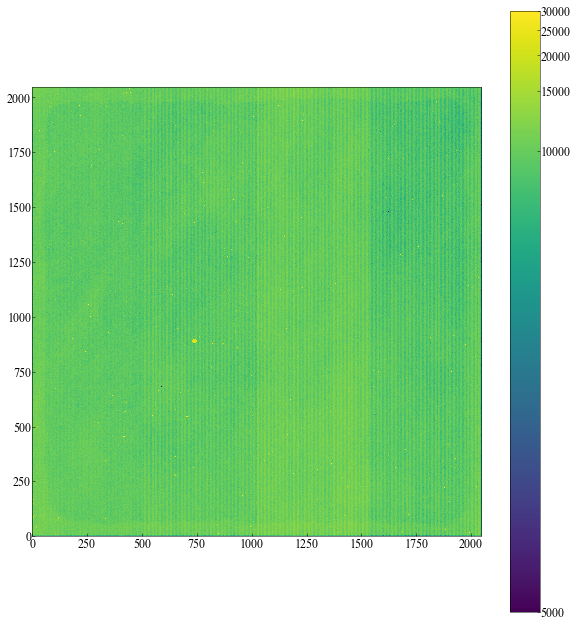

In [20]:
checkid = 'jw00042001001_01201_00001_nrcb1'

final_file = os.path.join(simulations_output_dir, '%s_uncal.fits'%checkid)
with fits.open(final_file) as hdulist:
    data = hdulist['SCI'].data
    hdulist.info()    
    
fig, ax = plt.subplots(figsize=(10, 10))
norm = simple_norm(data[0, -1, :, :], stretch='log', min_cut=5000, max_cut=30000)
cax = ax.imshow(data[0, -1, :, :], norm=norm)
cbar = fig.colorbar(cax)
plt.show()

### Next : Reduce uncal images with pipeline! (in a different notebook.)